
# Atlas-voting decision regions-scorer

Developed  by Frank Greco & Orest Xherja for analysing Atlas transcript data

## Synopsis
Three classifiers are initialized (`DecisionTreeClassifier`,
`KNeighborsClassifier`, and `SVC`) and used to initialize a
soft-voting `VotingClassifier` with weights [2, 1, 2].

A N-B classifier is trained using the NLTK-chat corpus to identify speech acts in text. 

The classifier is used to build a vector of speech acts for each transcript.

These vectors become training and test feature information which is fed to the above
classifiers, using the a specific tag present/not present vector as the label data.


In [1]:
#This may no longer be needed as we are not plotting...

%matplotlib inline
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload

## Imports

In [2]:
import sys
import os
#sys.path.append('/Users/fjgreco/Dev-Atlas')
#sys.path.insert(0, os.path.abspath(".."))

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
import nltk
# nltk.download()
nltk.data.path.append("/project/rcc/deep_learning_hack/nltk_data/")

In [4]:
# Run this once

import json
import numpy as np

from itertools import product

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
import collections

import dialogue_act as da


Create Speech Act Classifier
Accuracy
0.668


## External dependencies
dialgue_act.py depend on:
    nltk & nltk.corpus.nps_chat.xml_posts()
    frame_stack.py called by dialogue_act

text_dict5.json

Optional: X_tw08.p  contains the  2D tone analysis feature vectors for the transcripts

In [5]:
# Using a dictionary containing the transcript text, 
# returns a tf-idf matrix for the transcript corpus.

def tfidf(train_dict):

    print ("# retained documents:", len(train_dict))

    train_set = []

    #od = collections.OrderedDict(sorted(train_dict.items()))
    #for x in od.keys():
    #    train_set.append(od[x]['text'])
    
    for x in train_dict.keys():
        train_set.append(train_dict[x]['text'])

    vectorizer1 = HashingVectorizer()
    vectorizer2 = TfidfVectorizer(ngram_range=(1, 1))
    vectorizer3 = CountVectorizer()

    matrix_train1 = vectorizer1.fit_transform(train_set)  # finds the Hashing score with normalization
    cosine_scores1 = cosine_similarity(matrix_train1, matrix_train1)
    matrix_train2 = vectorizer2.fit_transform(train_set)  # finds the tfidf score with normalization
    cosine_scores2 = cosine_similarity(matrix_train2, matrix_train2)
    matrix_train3 = vectorizer3.fit_transform(train_set)  # finds the Count score with normalization
    cosine_scores3 = cosine_similarity(matrix_train3, matrix_train3)
    # [n:m] controls what document[s] are  compared to. Comparison values are stored as lists in a list.
    # [0:1] causes he first element of tfidf_matrix_train to me compared to the remaining elements.

    #for item in zip(doc_ids, doc_names,cosine_scores[0]):
    #   print (item)
    return matrix_train2.todense()

In [6]:
# Proxy routine that reads a pre-built json file containing a curated set of transcripts and associated 
# feature information. This json/dictionary approach was taken to minimized time consuming file I/O 
# and cloud based service interactions.   
def make_tfidf_vectors(text_dict='text_dict5.json'):
    import json
    
    print("Started. make_tfidf_vectors...")
    
    with open(text_dict) as data_file:
        text_dict = json.load(data_file)
        
    return tfidf(text_dict)

In [7]:
# Returns a vector (y) of class  labels, one for each transcript, indicating whether the input tag was assigned to
# the associated transcripts. (Each  transcript is associated with a y component that align
# aligns withe  a row featue vector in the X training matrix.)

def make_y_vectors(text_dict='text_dict5.json', tag='TWXX',limit=200):
    #print("Started make_y_vectors...")
    # Read JSON file
 
    count = 0

    with open(text_dict) as data_file:
        text_dict = json.load(data_file)

    y_pre=[]
    
    for key in text_dict.keys():

        count+= 1

        if tag in text_dict[key]['tags']:
            v = 1

        else:
            v = 0

        y_pre.append([v])

        if count == limit:
            break


    #print (len(y_pre))

    y = np.array(y_pre)


    return y.ravel(1)

In [8]:
# Using the N-B classifier, returns the speech act vector for each transript 

def make_sac_vectors(text_dict='text_dict5.json', limit=217):
    print("Started make_sac_vectors...")
    
    count = 0

    with open(text_dict) as data_file:
        text_dict = json.load(data_file)

    X_pre=[]

    for key in text_dict.keys():

        count+= 1

        #print ('Count: {}, key: {}'.format(count,key))


        #tone_r = tone_analyzer.tone(text_dict[key]['text'])

        sac= da.speech_act_vector(text_dict[key]['text'])
        
        
        #X_pre.append([tone_r["document_tone"]["tone_categories"][1]['tones'][0]["score"],
        #              tone_r["document_tone"]["tone_categories"][2]['tones'][4]["score"]])

        #print([sac[key2] for key2 in sac.keys()])

        X_pre.append([sac[key2] for key2 in sac.keys()])


        #print (json.dumps(tone_r,indent=2))

        if count == limit:
            break


    print (len(X_pre))


    #X = np.array(X_pre)
    flat_list=[item for sublist in X_pre for item in sublist]
    X_sac=np.array(flat_list).reshape((217,15))##

    return X_sac

## Build X (train/test) matrix; stack various feature vectors as desired

In [9]:

# Uncomment the following two lines to restore the "tone analysis" vector set.
# import pickle
# X_twa = pickle.load(open("X_tw08.p","rb"))

# Uncomment the following to generate a tf-idf vector set (vector)
X_tfidf=make_tfidf_vectors()


# The following generated the speech act vector set (matrix)
X_sac = make_sac_vectors(limit=217)

# X iss picked up by the subsequent multi-method classifiers.
X=X_sac
#X=X_tfidf

# Pick and choice what features to incorporate
#X=np.hstack((X_tfidf,X_sac))
#X=np.hstack((X_twa,X_sac))
#X=X_twa

print(X)


Started. make_tfidf_vectors...
# retained documents: 217
Started make_sac_vectors...
217
[[0.01748252 0.09090909 0.02097902 ... 0.         0.         0.        ]
 [0.05309735 0.07079646 0.00884956 ... 0.         0.         0.        ]
 [0.05       0.05       0.05       ... 0.         0.         0.        ]
 ...
 [0.03404255 0.08510638 0.00851064 ... 0.         0.00425532 0.        ]
 [0.03928571 0.12857143 0.02142857 ... 0.         0.         0.        ]
 [0.0210084  0.07983193 0.00840336 ... 0.         0.         0.        ]]


In [10]:
# The main mult-classifier function...

def fit(X,y,tag,n_shuffles=5):
    print ('\n'+tag)
    
    score_totals=[0,0,0,0]
    split=100

    for j in range(n_shuffles):
        #print("\nRun:{}".format(j))
        # Training classifiers
        clf1 = DecisionTreeClassifier(max_depth=4)
        clf2 = KNeighborsClassifier(n_neighbors=7)
        clf3 = SVC(kernel='rbf', probability=True)
        eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                            ('svc', clf3)],
                                voting='soft', weights=[2, 1, 2])

        clf1.fit(X[:split], y[:split])
        clf2.fit(X[:split], y[:split])
        clf3.fit(X[:split], y[:split])
        eclf.fit(X[:split], y[:split])


        """
        # Plotting decision regions
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
        """                 


        for idx1, idx, clf, tt in zip([0,1,2,3],product([0, 1], [0, 1]),
                                [clf1, clf2, clf3, eclf],
                                ['Decision Tree (depth=4)', 'KNN (k=7)','Kernel SVM', 'Soft Voting']):

            clf.fit(X[:split],y[:split])
            Z=clf.predict(X[split:])
            score=accuracy_score(y[split:],Z)
            #print(clf.__class__.__name__,score)
            score_totals[idx1] += score

            #Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) # Not apropos here

            #print ("Two (same) target predictions ===>")
            #print(clf.predict([[  0.00000000e+00 ,  1.00000000e+00 ,  3.47531000e-01  , 4.33134000e-01],[  0.00000000e+00 ,  1.00000000e+00  , 3.47531000e-01 ,  4.33134000e-01]]))



        X, y = shuffle(X, y, random_state=0)

    methods=['Decision Tree (depth=4)', 'KNN (k=7)','Kernel SVM', 'Soft Voting']
    
    for idx1, total in enumerate(score_totals):
        print ("idx:{} average score: {}".format(methods[idx1], total/n_shuffles))


In [11]:
# Calls the above classifier for each tag in the list. Within each instance, the data is 
# shuffled and the various classifiers are called ns times.

# special note: to print the accuray scores for each of the runs, uncomment the 
# appropriate print statments in the fit routine

ns=5  #number of shuffles
print('#shuffles:{}'.format(ns))
for tag in ['TW01','TW02','TW03','TW04','TW05','TW06','TW06s','TW07','TW08','TW09','TW09s',
           'TW10','TW11','TW13','TW15','TW16','TW17','TW18','TW19','TW20','TW22','TW23','TW24']:
    y=make_y_vectors(text_dict='text_dict5.json',tag=tag,limit=217)
    fit(X,y,tag,n_shuffles=ns)


#shuffles:5

TW01
idx:Decision Tree (depth=4) average score: 0.5521367521367522
idx:KNN (k=7) average score: 0.5538461538461539
idx:Kernel SVM average score: 0.4735042735042735
idx:Soft Voting average score: 0.5452991452991454


/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel/__main__.py:37: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu


TW02
idx:Decision Tree (depth=4) average score: 0.5709401709401709
idx:KNN (k=7) average score: 0.5487179487179488
idx:Kernel SVM average score: 0.5794871794871794
idx:Soft Voting average score: 0.5846153846153846

TW03
idx:Decision Tree (depth=4) average score: 0.8324786324786325
idx:KNN (k=7) average score: 0.9076923076923078
idx:Kernel SVM average score: 0.9094017094017095
idx:Soft Voting average score: 0.8991452991452992

TW04


/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: De

idx:Decision Tree (depth=4) average score: 0.8222222222222223
idx:KNN (k=7) average score: 0.8923076923076924
idx:Kernel SVM average score: 0.8957264957264958
idx:Soft Voting average score: 0.8717948717948717

TW05
idx:Decision Tree (depth=4) average score: 0.6
idx:KNN (k=7) average score: 0.6239316239316239
idx:Kernel SVM average score: 0.6820512820512821
idx:Soft Voting average score: 0.6239316239316239

TW06
idx:Decision Tree (depth=4) average score: 0.7128205128205128
idx:KNN (k=7) average score: 0.7777777777777778
idx:Kernel SVM average score: 0.7863247863247863
idx:Soft Voting average score: 0.7384615384615385


/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel/__main__.py:37: DeprecationW


TW06s
idx:Decision Tree (depth=4) average score: 0.8256410256410256
idx:KNN (k=7) average score: 0.9042735042735043
idx:Kernel SVM average score: 0.9042735042735043
idx:Soft Voting average score: 0.9042735042735043

TW07
idx:Decision Tree (depth=4) average score: 0.8051282051282052
idx:KNN (k=7) average score: 0.8837606837606838
idx:Kernel SVM average score: 0.8837606837606838
idx:Soft Voting average score: 0.876923076923077

TW08


/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel/__main__.py:37: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

idx:Decision Tree (depth=4) average score: 0.5794871794871795
idx:KNN (k=7) average score: 0.6085470085470085
idx:Kernel SVM average score: 0.6170940170940171
idx:Soft Voting average score: 0.6102564102564103

TW09
idx:Decision Tree (depth=4) average score: 0.747008547008547
idx:KNN (k=7) average score: 0.8461538461538461
idx:Kernel SVM average score: 0.8547008547008547
idx:Soft Voting average score: 0.8170940170940171

TW09s
idx:Decision Tree (depth=4) average score: 0.8
idx:KNN (k=7) average score: 0.8752136752136753
idx:Kernel SVM average score: 0.8803418803418804
idx:Soft Voting average score: 0.8700854700854702


/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: De


TW10
idx:Decision Tree (depth=4) average score: 0.8803418803418804
idx:KNN (k=7) average score: 0.9299145299145299
idx:Kernel SVM average score: 0.9299145299145299
idx:Soft Voting average score: 0.9247863247863248

TW11
idx:Decision Tree (depth=4) average score: 0.7914529914529914
idx:KNN (k=7) average score: 0.888888888888889
idx:Kernel SVM average score: 0.8905982905982907
idx:Soft Voting average score: 0.8581196581196583

TW13


/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel/__main__.py:37: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

idx:Decision Tree (depth=4) average score: 0.629059829059829
idx:KNN (k=7) average score: 0.6393162393162393
idx:Kernel SVM average score: 0.7179487179487178
idx:Soft Voting average score: 0.6512820512820513

TW15
idx:Decision Tree (depth=4) average score: 0.7606837606837608
idx:KNN (k=7) average score: 0.8222222222222223
idx:Kernel SVM average score: 0.8376068376068376
idx:Soft Voting average score: 0.7897435897435898

TW16
idx:Decision Tree (depth=4) average score: 0.7076923076923076
idx:KNN (k=7) average score: 0.7777777777777777
idx:Kernel SVM average score: 0.7965811965811966
idx:Soft Voting average score: 0.7059829059829059


/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel/__main__.py:37: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu


TW17
idx:Decision Tree (depth=4) average score: 0.6461538461538462
idx:KNN (k=7) average score: 0.7418803418803419
idx:Kernel SVM average score: 0.764102564102564
idx:Soft Voting average score: 0.6632478632478633

TW18
idx:Decision Tree (depth=4) average score: 0.8136752136752137
idx:KNN (k=7) average score: 0.8786324786324787
idx:Kernel SVM average score: 0.8803418803418804
idx:Soft Voting average score: 0.8632478632478632

TW19


/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel/__main__.py:37: DeprecationW

idx:Decision Tree (depth=4) average score: 0.8803418803418804
idx:KNN (k=7) average score: 0.917948717948718
idx:Kernel SVM average score: 0.917948717948718
idx:Soft Voting average score: 0.9128205128205129

TW20
idx:Decision Tree (depth=4) average score: 0.85982905982906
idx:KNN (k=7) average score: 0.9435897435897436
idx:Kernel SVM average score: 0.9435897435897436
idx:Soft Voting average score: 0.9435897435897436

TW22


/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: De

idx:Decision Tree (depth=4) average score: 0.7914529914529915
idx:KNN (k=7) average score: 0.8700854700854702
idx:Kernel SVM average score: 0.8803418803418804
idx:Soft Voting average score: 0.8444444444444444

TW23
idx:Decision Tree (depth=4) average score: 0.8
idx:KNN (k=7) average score: 0.8581196581196581
idx:Kernel SVM average score: 0.8837606837606838
idx:Soft Voting average score: 0.8547008547008547

TW24
idx:Decision Tree (depth=4) average score: 0.6017094017094017
idx:KNN (k=7) average score: 0.6905982905982906
idx:Kernel SVM average score: 0.7128205128205127
idx:Soft Voting average score: 0.6307692307692307


/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: De

In [12]:
# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

# load pima indians dataset
#dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
Y=y
# create model
input_dim = 15 #11435
model = Sequential()
model.add(Dense(217, input_dim=input_dim, activation='relu'))
model.add(Dense(input_dim, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X, Y, epochs=1, batch_size=10)
# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/1
217/217 [==============================] - 0s 159us/step

acc: 71.43%


In [13]:
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import pickle
#import data
#from my_metrics import my_me
import keras.backend as K

def my_me(y_true, y_pred):
            return K.std(y_true-y_pred)

#N = 10000
epochs = 10

#d = data.data(size=N, f = lambda x: (x-1)**3, left=-2, right=2, amplitude=1.0)
#((x_train,y_train),(x_validation,y_validation),(x_test,y_test)) = d.compute_tvt(split=(0.9, 0.05))

split=100
x_train=X[:split]
y_train=y[:split]
x_validation=X[split:split+50]
y_validation=y[split:split+50]

x_test=x_validation
y_test=y_validation


f=open("output/test.pickle","wb")
pickle.dump((x_test,y_test),f)
f.close()

inputs = Input(shape=(input_dim,))
# inputs = Input(shape=(15,))
x = Dense(100, activation='relu')(inputs)
predictions = Dense(1)(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='sgd', loss='mse', metrics=[my_me])

h  = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=epochs, batch_size=50,
               callbacks=[ModelCheckpoint('output/best_checkpoint.h5', monitor='val_loss', save_best_only=True, verbose=1)])

model.save("output/final.h5")

f=open("output/history.pickle","wb")
pickle.dump((h.history,h.params), f)
f.close()



Train on 100 samples, validate on 50 samples
Epoch 1/10
100/100 [==============================] - 0s 2ms/step - loss: 0.2456 - my_me: 0.4445 - val_loss: 0.2334 - val_my_me: 0.4441
Epoch 2/10
100/100 [==============================] - 0s 377us/step - loss: 0.2369 - my_me: 0.4443 - val_loss: 0.2263 - val_my_me: 0.4441
Epoch 3/10
100/100 [==============================] - 0s 222us/step - loss: 0.2297 - my_me: 0.4429 - val_loss: 0.2207 - val_my_me: 0.4442
Epoch 4/10
100/100 [==============================] - 0s 205us/step - loss: 0.2238 - my_me: 0.4432 - val_loss: 0.2161 - val_my_me: 0.4443
Epoch 5/10
100/100 [==============================] - 0s 149us/step - loss: 0.2189 - my_me: 0.4441 - val_loss: 0.2123 - val_my_me: 0.4443
Epoch 6/10
100/100 [==============================] - 0s 251us/step - loss: 0.2150 - my_me: 0.4431 - val_loss: 0.2093 - val_my_me: 0.4444
Epoch 7/10
100/100 [==============================] - 0s 223us/step - loss: 0.2120 - my_me: 0.4371 - val_loss: 0.2070 - val_my_me

/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/software/Anaconda3-5.0.1-e

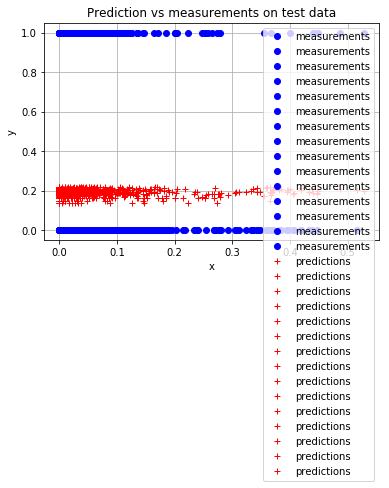

history= {'val_loss': [0.2333521991968155, 0.22632867097854614, 0.22065964341163635, 0.21607264876365662, 0.21234504878520966, 0.20933832228183746, 0.2069617211818695, 0.20503491163253784, 0.20346471667289734, 0.2022257000207901], 'val_my_me': [0.44405752420425415, 0.44413238763809204, 0.44421032071113586, 0.44426947832107544, 0.44432076811790466, 0.44437575340270996, 0.44442617893218994, 0.44446754455566406, 0.4445072114467621, 0.4445391893386841], 'loss': [0.24562963098287582, 0.23685134947299957, 0.2296835035085678, 0.22378525882959366, 0.21892666816711426, 0.21500207483768463, 0.21202006936073303, 0.2092418298125267, 0.20698093622922897, 0.20514702051877975], 'my_me': [0.44445089995861053, 0.4442644268274307, 0.4429401308298111, 0.44316788017749786, 0.44413840770721436, 0.443133220076561, 0.4371459186077118, 0.4407863914966583, 0.4427814334630966, 0.4439936876296997]}
params= {'batch_size': 50, 'epochs': 10, 'steps': None, 'samples': 100, 'verbose': 1, 'do_validation': True, 'metri

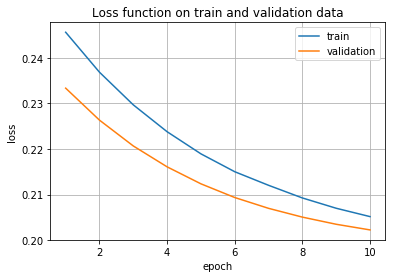

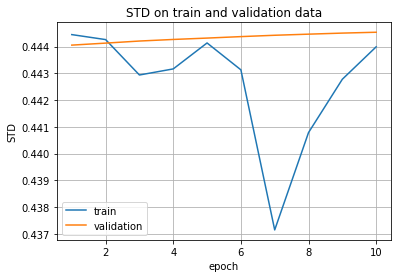

model summary=
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1600      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________
model to_json= {"class_name": "Model", "config": {"name": "model_1", "layers": [{"name": "input_1", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 15], "dtype": "float32", "sparse": false, "name": "input_1"}, "inbound_nodes": []}, {"name": "dense_4", "class_name": "Dense", "config": {"name": "dense_4", "trainable": true, "units": 100, "activation": "relu", "use_bias"

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

<Figure size 432x288 with 0 Axes>

In [14]:
from keras.models import load_model
import pickle
import matplotlib as mpl 
mpl.use('Agg')
import matplotlib.pyplot as plt
#from my_metrics import my_me
import numpy as np

model = load_model("output/best_checkpoint.h5", custom_objects={"my_me":my_me})

x_test, y_test = pickle.load(open("output/test.pickle","rb"))
y_test_predict = model.predict(x_test)
plt.plot(x_test, y_test, 'bo', label = "measurements")
plt.plot(x_test, y_test_predict, 'r+', label = "predictions")
plt.title("Prediction vs measurements on test data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.savefig("output/prediction.png")
plt.show()
plt.clf()

history, params  = pickle.load(open("output/history.pickle","rb"))
print("history=",history)
print("="*50)
print("params=",params)
print("="*50)

plt.plot(range(1, params['epochs']+1), history['loss'], label="train")
plt.plot(range(1, params['epochs']+1), history['val_loss'], label="validation")
plt.legend()
plt.title("Loss function on train and validation data")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.savefig("output/loss.png")
plt.show()
plt.clf()

plt.plot(range(1, params['epochs']+1), history['my_me'], label="train")
plt.plot(range(1, params['epochs']+1), history['val_my_me'], label="validation")
plt.legend()
plt.title("STD on train and validation data")
plt.xlabel("epoch")
plt.ylabel("STD")
plt.grid(True)
plt.savefig("output/std.png")
plt.show()
plt.clf()

print("model summary=")
model.summary()
print("="*50)
print("model to_json=",model.to_json())
print("="*50)




In [15]:
from keras.utils import plot_model
plot_model(model, to_file='output/model.png', show_shapes=True)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.